Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

import numpy as np
import tensorflow as tf
import pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

![](https://raw.githubusercontent.com/ritchieng/machine-learning-nanodegree/master/deep_learning/deep_neural_nets/dnn12.png)

In [5]:
# Logistic model

batch_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
        + beta * tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: 0.001}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 21.050961
Minibatch accuracy: 3.9%
Validation accuracy: 10.6%
Minibatch loss at step 500: 3.529849
Minibatch accuracy: 67.2%
Validation accuracy: 75.7%
Minibatch loss at step 1000: 1.681666
Minibatch accuracy: 79.7%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 1.350154
Minibatch accuracy: 77.3%
Validation accuracy: 80.9%
Minibatch loss at step 2000: 1.002482
Minibatch accuracy: 81.2%
Validation accuracy: 80.6%
Minibatch loss at step 2500: 0.979264
Minibatch accuracy: 76.6%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 0.755158
Minibatch accuracy: 76.6%
Validation accuracy: 82.3%
Test accuracy: 88.8%


In [7]:
# again, tuning the new parameter

num_steps = 3001
beta_vals = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for beta_val in beta_vals:
    print("beta:", beta_val)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_val}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Accuracy:', accuracy_val[-1], '\n')

beta: 0.0001
Initialized
Accuracy: 86.97 

beta: 0.000125892541179
Initialized
Accuracy: 86.77 

beta: 0.000158489319246
Initialized
Accuracy: 86.68 

beta: 0.000199526231497
Initialized
Accuracy: 87.31 

beta: 0.000251188643151
Initialized
Accuracy: 87.5 

beta: 0.000316227766017
Initialized
Accuracy: 88.03 

beta: 0.000398107170553
Initialized
Accuracy: 87.98 

beta: 0.000501187233627
Initialized
Accuracy: 88.02 

beta: 0.00063095734448
Initialized
Accuracy: 88.56 

beta: 0.000794328234724
Initialized
Accuracy: 88.93 

beta: 0.001
Initialized
Accuracy: 89.0 

beta: 0.00125892541179
Initialized
Accuracy: 88.94 

beta: 0.00158489319246
Initialized
Accuracy: 89.11 

beta: 0.00199526231497
Initialized
Accuracy: 88.96 

beta: 0.00251188643151
Initialized
Accuracy: 88.94 

beta: 0.00316227766017
Initialized
Accuracy: 88.9 

beta: 0.00398107170553
Initialized
Accuracy: 88.94 

beta: 0.00501187233627
Initialized
Accuracy: 88.99 

beta: 0.0063095734448
Initialized
Accuracy: 89.06 

beta: 0.00

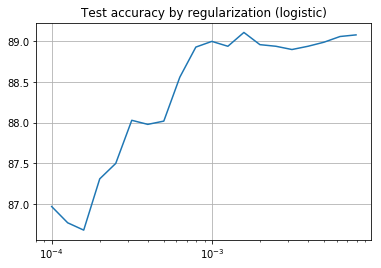

In [11]:
import matplotlib.pyplot as plt
plt.semilogx(beta_vals, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()


#### NN with relu

In [12]:
# NN with relu

batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)


    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
        + beta*(tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2)) )

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:0.01}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 3493.973145
Minibatch accuracy: 6.2%
Validation accuracy: 30.8%
Minibatch loss at step 500: 21.517811
Minibatch accuracy: 76.6%
Validation accuracy: 84.2%
Minibatch loss at step 1000: 0.886992
Minibatch accuracy: 85.9%
Validation accuracy: 84.2%
Minibatch loss at step 1500: 0.803465
Minibatch accuracy: 82.0%
Validation accuracy: 84.2%
Minibatch loss at step 2000: 0.712140
Minibatch accuracy: 83.6%
Validation accuracy: 83.9%
Minibatch loss at step 2500: 0.802180
Minibatch accuracy: 80.5%
Validation accuracy: 83.9%
Minibatch loss at step 3000: 0.731147
Minibatch accuracy: 84.4%
Validation accuracy: 84.2%
Test accuracy: 90.7%


In [14]:
# again, tuning the new parameter

num_steps = 3001
beta_vals = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for beta_val in beta_vals:
    print("beta:", beta_val)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_val}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Accuracy:', accuracy_val[-1], '\n')

beta: 0.0001
Initialized
Accuracy: 89.62 

beta: 0.000125892541179
Initialized
Accuracy: 89.46 

beta: 0.000158489319246
Initialized
Accuracy: 89.57 

beta: 0.000199526231497
Initialized
Accuracy: 89.12 

beta: 0.000251188643151
Initialized
Accuracy: 89.15 

beta: 0.000316227766017
Initialized
Accuracy: 90.5 

beta: 0.000398107170553
Initialized
Accuracy: 91.14 

beta: 0.000501187233627
Initialized
Accuracy: 91.31 

beta: 0.00063095734448
Initialized
Accuracy: 92.01 

beta: 0.000794328234724
Initialized
Accuracy: 92.53 

beta: 0.001
Initialized
Accuracy: 93.28 

beta: 0.00125892541179
Initialized
Accuracy: 93.52 

beta: 0.00158489319246
Initialized
Accuracy: 93.75 

beta: 0.00199526231497
Initialized
Accuracy: 93.38 

beta: 0.00251188643151
Initialized
Accuracy: 92.91 

beta: 0.00316227766017
Initialized
Accuracy: 92.85 

beta: 0.00398107170553
Initialized
Accuracy: 92.31 

beta: 0.00501187233627
Initialized
Accuracy: 91.92 

beta: 0.0063095734448
Initialized
Accuracy: 91.46 

beta: 0.

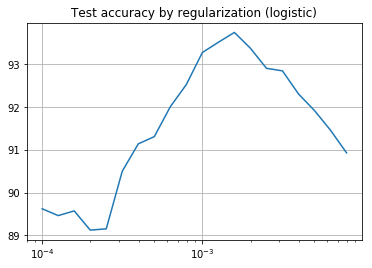

In [15]:
import matplotlib.pyplot as plt
plt.semilogx(beta_vals, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [ ]:
# NN with relu

batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)


    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
        + beta*(tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2)) )

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [ ]:
num_steps = 3001
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step % num_batches) * batch_size % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:0.01}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
